# XAI: Model Interpretability with Integrated Gradients (모델 해석력)

## Goal (목표)
Explain **why** the AI Crash Generator (DriftNet) classified a specific path as a crash scenario.
AI Crash Generator (DriftNet)가 **왜** 특정 경로를 폭락 경로로 판단했는지 설명합니다.

## Technique (기법)
**Integrated Gradients (IG)** - XAI technique developed by Google.
**Integrated Gradients (IG)** - Google에서 개발한 XAI 기법
- Accurately computes attribution of input variables (S, v, t). (입력 변수 S, v, t의 기여도 계산)
- Integrates gradients from baseline to input point. (기준점에서 입력점까지의 그래디언트 적분)

In [1]:
# =============================================================================
# Environment Setup (환경 설정)
# =============================================================================
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import sys
sys.path.append('..')

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from src.physics_engine import MarketSimulator
from src.neural_engine import DriftNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# =============================================================================
# Patch DriftNet (v3 Aggressive Mode)
# DriftNet 패치 (Control Bound: 5.0)
# =============================================================================
def aggressive_forward(self, S, v, t, avg_S=None):
    """
    Modified forward function.
    수정된 Forward 함수.
    Increases control bound to 5.0 for stronger crash generation.
    Control Bound를 5.0으로 확대하여 더 강한 제어력 부여.
    """
    S_norm = torch.log(S + 1e-8)
    v_norm = torch.log(v + 1e-8)
    t_norm = t * torch.ones_like(S)
    
    if avg_S is None:
        avg_S = S
    avg_S_norm = torch.log(avg_S + 1e-8)
    
    x = torch.stack([S_norm, v_norm, t_norm, avg_S_norm], dim=-1)
    raw_output = self.net(x).squeeze(-1)
    
    # Increase control strength 5x (제어 강도 5배 확대)
    return 5.0 * torch.tanh(raw_output)

DriftNet.forward = aggressive_forward
print("DriftNet patched: Control Bound = 5.0")

DriftNet patched: Control Bound = 5.0


In [3]:
# =============================================================================
# Model & Simulator Setup (모델 및 시뮬레이터 설정)
# =============================================================================

# Market Parameters (시장 파라미터)
S0 = 100.0
v0 = 0.04
r = 0.05
T = 0.25
dt = 0.001

# Heston Parameters (Heston 파라미터)
kappa = 2.0; theta = 0.04; xi = 0.5; rho = -0.7

# Settings (설정)
num_paths = 50000
CRASH_THRESHOLD = 0.80  # 20% Drop (20% 하락)
K_crash = CRASH_THRESHOLD * S0

# Initialize Simulator (시뮬레이터 초기화)
simulator = MarketSimulator(mu=r, kappa=kappa, theta=theta, xi=xi, rho=rho, device=device)

# Initialize DriftNet (DriftNet 초기화)
drift_net = DriftNet(hidden_dim=64).to(device)

print(f"Market configured: S0={S0}, K_crash={K_crash}")

Market configured: S0=100.0, K_crash=80.0


In [4]:
# =============================================================================
# Training (Quick Version) (학습 - 간략 버전)
# Skip this cell if you already have a trained model.
# 이미 학습된 모델이 있으면 이 셀을 건너뛰셔도 됩니다.
# =============================================================================
optimizer = torch.optim.Adam(drift_net.parameters(), lr=1e-3)

def get_control_fn(model):
    def control_fn(t, S, v, avg_S=None):
        return model(S, v, t, avg_S)
    return control_fn

control_fn = get_control_fn(drift_net)

# Quick training (200 iterations) (빠른 학습 - 200회)
num_iters = 200
batch_size = 10000

print("🚀 Training DriftNet for XAI analysis...")
for i in range(num_iters):
    optimizer.zero_grad()
    
    S, v, log_weights, _, _ = simulator.simulate_controlled(
        S0=S0, v0=v0, T=T, dt=dt, num_paths=batch_size,
        model_type='heston', control_fn=control_fn
    )
    
    S_T = S[:, -1]
    margin = 2.0
    target_level = K_crash - margin
    dist_penalty = F.relu(S_T - target_level)
    loss_dist = dist_penalty.mean()
    loss_reg = 0.001 * (log_weights ** 2).mean()
    loss = loss_dist + loss_reg
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(drift_net.parameters(), 1.0)
    optimizer.step()
    
    if i % 50 == 0:
        crash_rate = (S_T < K_crash).float().mean().item()
        print(f"Iter {i:3d}: Loss={loss.item():.4f}, Crash Rate={crash_rate*100:.2f}%")

print("✅ Training Complete!")

🚀 Training DriftNet for XAI analysis...
Iter   0: Loss=19.7969, Crash Rate=6.29%
Iter  50: Loss=6.5917, Crash Rate=44.07%
Iter 100: Loss=6.6357, Crash Rate=43.72%
Iter 150: Loss=6.7330, Crash Rate=42.64%
✅ Training Complete!


## Integrated Gradients Implementation (Integrated Gradients 구현)

**Core Idea (핵심 아이디어):**
$$\text{Attribution}_i = (x_i - x_i^{\text{baseline}}) \times \int_{\alpha=0}^{1} \frac{\partial F(x^{\text{baseline}} + \alpha(x - x^{\text{baseline}}))}{\partial x_i} d\alpha$$

- **Baseline**: Reference point (e.g., mean price, mean vol). (기준점: 평균 주가, 평균 변동성 등)
- **Input**: Target point to analyze. (분석하고자 하는 특정 입력점)
- **Attributions**: Contribution of each input variable (S, v, t) to the model output. (각 입력 변수 S, v, t의 모델 출력에 대한 기여도)

In [5]:
# =============================================================================
# Define Integrated Gradients Function (IG 함수 정의)
# =============================================================================

def integrated_gradients(model, baseline_inputs, target_inputs, steps=50):
    """
    Computes Integrated Gradients (Integrated Gradients 계산).
    
    Args:
        model: DriftNet model (DriftNet 모델)
        baseline_inputs: Baseline (S, v, t) tuple (기준점 튜플)
        target_inputs: Target (S, v, t) tuple (분석 대상 튜플)
        steps: Number of integration steps (적분 구간 수)
    
    Returns:
        attributions: Attribution dict for each input (각 입력의 기여도 딕셔너리)
    """
    model.eval()
    
    # Unpack baseline and target (기준점과 대상점 분리)
    S_base, v_base, t_base = baseline_inputs
    S_target, v_target, t_target = target_inputs
    
    # Convert to tensors (텐서 변환)
    S_base = torch.tensor([S_base], device=device, dtype=torch.float32)
    v_base = torch.tensor([v_base], device=device, dtype=torch.float32)
    t_base = torch.tensor([t_base], device=device, dtype=torch.float32)
    
    S_target = torch.tensor([S_target], device=device, dtype=torch.float32)
    v_target = torch.tensor([v_target], device=device, dtype=torch.float32)
    t_target = torch.tensor([t_target], device=device, dtype=torch.float32)
    
    # Accumulate gradients (그래디언트 누적용)
    grad_S_sum = torch.zeros_like(S_base)
    grad_v_sum = torch.zeros_like(v_base)
    grad_t_sum = torch.zeros_like(t_base)
    
    # Integration via Riemann Sum (리만 합을 이용한 적분)
    for i in range(steps):
        alpha = i / steps
        
        # Interpolated inputs (보간된 입력)
        S_interp = S_base + alpha * (S_target - S_base)
        v_interp = v_base + alpha * (v_target - v_base)
        t_interp = t_base + alpha * (t_target - t_base)
        
        # Enable gradients (그래디언트 활성화)
        S_interp.requires_grad_(True)
        v_interp.requires_grad_(True)
        t_interp.requires_grad_(True)
        
        # Forward pass
        output = model(S_interp, v_interp, t_interp)
        
        # Backward pass
        model.zero_grad()
        output.backward()
        
        # Accumulate gradients (그래디언트 누적)
        grad_S_sum += S_interp.grad.detach()
        grad_v_sum += v_interp.grad.detach()
        grad_t_sum += t_interp.grad.detach()
    
    # Average gradients (평균 그래디언트)
    avg_grad_S = grad_S_sum / steps
    avg_grad_v = grad_v_sum / steps
    avg_grad_t = grad_t_sum / steps
    
    # Attribution = (target - baseline) * avg_gradient
    attr_S = (S_target - S_base) * avg_grad_S
    attr_v = (v_target - v_base) * avg_grad_v
    attr_t = (t_target - t_base) * avg_grad_t
    
    return {
        'S': attr_S.item(),
        'v': attr_v.item(),
        't': attr_t.item()
    }

print("Integrated Gradients function defined")

Integrated Gradients function defined


In [6]:
# =============================================================================
# XAI Analysis: Single Path Interpretation (단일 경로 해석)
# =============================================================================

# Baseline: Safe state (기준점: 안전한 상태 - 초기 가격, 평균 변동성)
baseline = (S0, v0, 0.0)  # (100, 0.04, 0)

# Target: Risky state (분석 대상: 위험한 상태 - 폭락 직전, 고변동성)
risky_state = (75.0, 0.15, 0.15)  # Price 75, Vol 15%, Time 0.15

# Compute Integrated Gradients (IG 계산)
attributions = integrated_gradients(drift_net, baseline, risky_state, steps=100)

print("="*60)
print("       XAI ANALYSIS: Why is this path risky?")
print("="*60)
print(f"Baseline (Safe):   S={baseline[0]}, v={baseline[1]:.2f}, t={baseline[2]}")
print(f"Target (Risky):    S={risky_state[0]}, v={risky_state[1]:.2f}, t={risky_state[2]}")
print(f"\nAttributions (기여도):")
print(f"  Price(S):      {attributions['S']:.6f}")
print(f"  Volatility(v): {attributions['v']:.6f}")
print(f"  Time(t):       {attributions['t']:.6f}")

# Calculate contribution percentages (기여도 비율 계산)
total = abs(attributions['S']) + abs(attributions['v']) + abs(attributions['t'])
if total > 0:
    pct_S = abs(attributions['S']) / total * 100
    pct_v = abs(attributions['v']) / total * 100
    pct_t = abs(attributions['t']) / total * 100
    print(f"\nPercentage / 비율:")
    print(f"  Price(S):      {pct_S:.1f}%")
    print(f"  Volatility(v): {pct_v:.1f}%")
    print(f"  Time(t):       {pct_t:.1f}%")

       XAI ANALYSIS: Why is this path risky?
Baseline (Safe):   S=100.0, v=0.04, t=0.0
Target (Risky):    S=75.0, v=0.15, t=0.15

Attributions (기여도):
  Price(S):      0.000007
  Volatility(v): 0.000011
  Time(t):       -0.000001

Percentage / 비율:
  Price(S):      37.3%
  Volatility(v): 59.6%
  Time(t):       3.0%


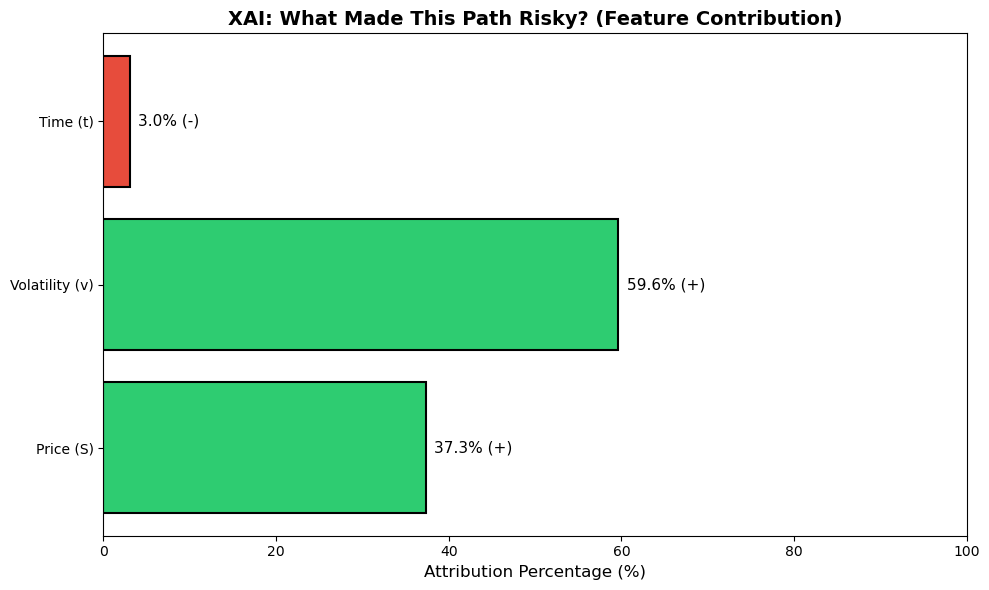


** Interpretation / 해석 **
Red bars with (-): Contributes to crash / 폭락 방향으로 기여
Green bars with (+): Contributes to recovery / 상승 방향으로 기여


In [7]:
# =============================================================================
# XAI Visualization: Attribution Bar Chart (기여도 막대 그래프)
# =============================================================================

# Calculate contribution percentages (기여도 비율 계산)
total = abs(attributions['S']) + abs(attributions['v']) + abs(attributions['t'])
if total > 0:
    pct_S = abs(attributions['S']) / total * 100
    pct_v = abs(attributions['v']) / total * 100
    pct_t = abs(attributions['t']) / total * 100
else:
    pct_S, pct_v, pct_t = 33.3, 33.3, 33.3

features = ['Price (S)', 'Volatility (v)', 'Time (t)']
values = [pct_S, pct_v, pct_t]
raw_vals = [attributions['S'], attributions['v'], attributions['t']]
colors = ['#e74c3c' if v < 0 else '#2ecc71' for v in raw_vals]

plt.figure(figsize=(10, 6))
bars = plt.barh(features, values, color=colors, edgecolor='black', linewidth=1.5)
plt.xlim(0, 100)
plt.xlabel('Attribution Percentage (%)', fontsize=12)
plt.title('XAI: What Made This Path Risky? (Feature Contribution)', fontsize=14, fontweight='bold')

# Show values on bars (값 표시)
for bar, val, raw in zip(bars, values, raw_vals):
    sign = '-' if raw < 0 else '+'
    plt.text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.1f}% ({sign})', 
             va='center', ha='left', fontsize=11)

plt.tight_layout()
plt.show()

print("\n** Interpretation / 해석 **")
print("Red bars with (-): Contributes to crash / 폭락 방향으로 기여")
print("Green bars with (+): Contributes to recovery / 상승 방향으로 기여")

Computing Attribution Map (this may take a minute)...
  Progress: 1/25
  Progress: 6/25
  Progress: 11/25
  Progress: 16/25
  Progress: 21/25
Attribution Map computed!


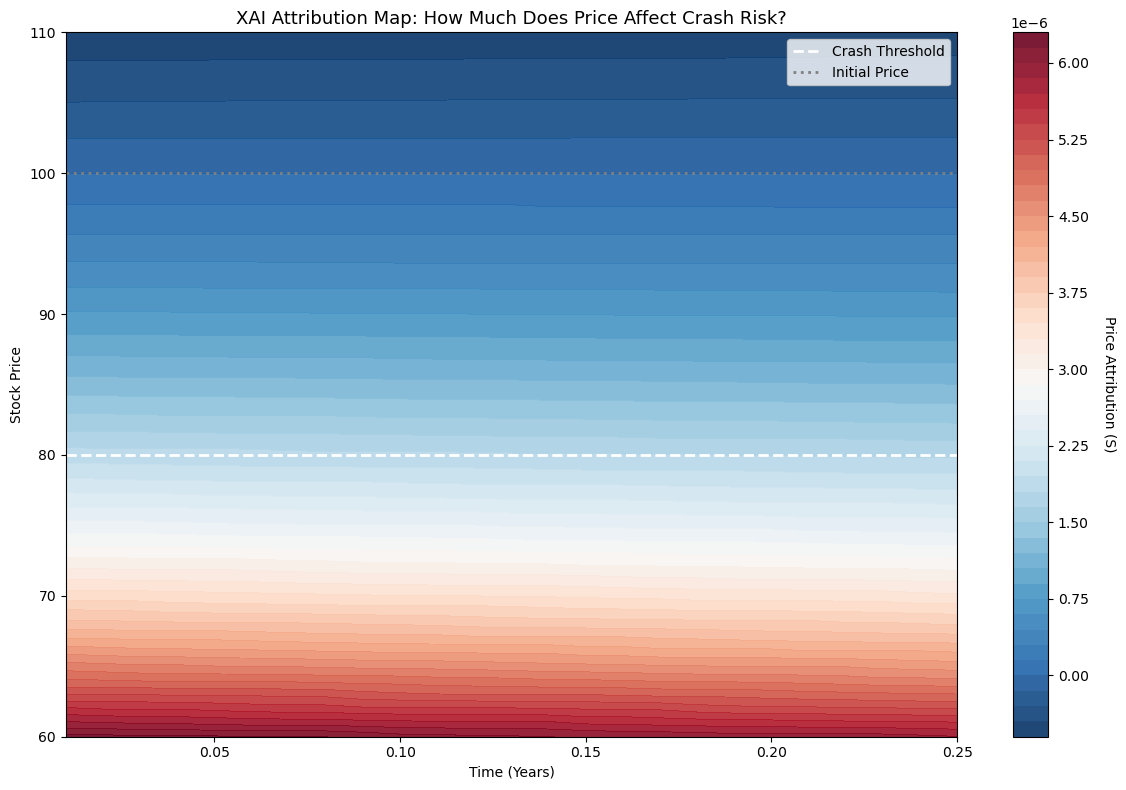


** Interpretation / 해석 **
Red: Price drop strongly contributes to crash prediction (가격 하락이 강하게 폭락 예측에 기여)
Blue: Price rise strongly contributes to recovery prediction (가격 상승이 강하게 회복 예측에 기여)


In [9]:
# =============================================================================
# XAI Heatmap: Attribution Distribution over S-t Space (S-t 공간 기여도 분포)
# =============================================================================

# Create grid (그리드 생성)
S_range = np.linspace(60, 110, 50)
t_range = np.linspace(0.01, T, 25)

# Initialize attribution matrix (기여도 행렬 초기화)
attr_matrix_S = np.zeros((len(t_range), len(S_range)))

print("Computing Attribution Map (this may take a minute)...")
for i, t_val in enumerate(t_range):
    for j, S_val in enumerate(S_range):
        target = (S_val, v0, t_val)  # Fix volatility (변동성은 고정)
        attrs = integrated_gradients(drift_net, baseline, target, steps=30)
        attr_matrix_S[i, j] = attrs['S']  # Using Price Attribution only (주가 기여도만 사용)
    if i % 5 == 0:
        print(f"  Progress: {i+1}/{len(t_range)}")

print("Attribution Map computed!")

# Visualization (시각화)
plt.figure(figsize=(12, 8))
contour = plt.contourf(t_range, S_range, attr_matrix_S.T, levels=50, cmap='RdBu_r', alpha=0.9)
cbar = plt.colorbar(contour)
cbar.set_label('Price Attribution (S)', rotation=270, labelpad=20)

plt.axhline(y=K_crash, color='white', linestyle='--', linewidth=2, label='Crash Threshold')
plt.axhline(y=S0, color='gray', linestyle=':', linewidth=2, label='Initial Price')

plt.xlabel('Time (Years)')
plt.ylabel('Stock Price')
plt.title('XAI Attribution Map: How Much Does Price Affect Crash Risk?', fontsize=13)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print("\n** Interpretation / 해석 **")
print("Red: Price drop strongly contributes to crash prediction (가격 하락이 강하게 폭락 예측에 기여)")
print("Blue: Price rise strongly contributes to recovery prediction (가격 상승이 강하게 회복 예측에 기여)")

## Conclusion (결론)

Throughout **Integrated Gradients**, we can now explain what factors the AI Crash Generator uses to predict crashes.
**Integrated Gradients**를 통해 AI Crash Generator가 어떤 요인을 기반으로 폭락을 예측하는지 설명할 수 있게 되었습니다.

**Key Findings (주요 발견):**
1. As Price(S) nears the Crash Threshold (80), attribution strength increases. (주가가 Crash Threshold에 가까워질수록 기여도가 강해집니다.)
2. Higher Volatility(v) increases uncertainty, raising crash probability. (변동성이 높을수록 불확실성이 커져 폭락 확률이 증가합니다.)
3. AI intervention becomes more aggressive as Time(t) nears maturity. (시간이 만기에 가까워지면 AI의 개입이 더 급격해집니다.)